## Import

In [29]:
import os 
import time 
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import cv2
import torch
from torch import nn, optim
import segmentation_models_pytorch as smp
import segmentation_models_pytorch.utils as utils
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image


## Data handling (loading+transforming+augumentation)

In [57]:
image_transform = transforms.Compose([transforms.Resize((256, 256), 2),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                                      ]) # imagenet stats
        
mask_transform = transforms.Compose([transforms.Resize((256, 256), 2),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor()])

In [58]:
class LipsSet(Dataset):
    def __init__(self, parent_dir, image_dir, mask_dir, image_transform, mask_transform):

        self.mask_list = glob.glob(parent_dir+'/'+mask_dir+'/*')
        self.mask_list.sort()
        self.image_list = []

        # an image exists for every mask
        for path in self.mask_list:
            self.image_list.append(path.replace(mask_dir, image_dir))
        self.mask_list = self.mask_list

        self.image_transform = image_transform
        self.mask_transform = mask_transform
                
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):

        img_path = self.image_list[idx]
        mask_path = self.mask_list[idx]
        
        img = Image.open(img_path).convert("RGB")

        mask = Image.open(mask_path).convert("L")  

        img = self.image_transform(img)
        
        mask = self.mask_transform(mask)
        
        mask = (mask > 0).float()  

        return img, mask
        

In [59]:
img = Image.open('images/0.png').convert("RGB")
mask = Image.open('proper_masks/0.png').convert("L")  

img = image_transform(img)
        
mask = mask_transform(mask)
        
mask = (mask > 0).float() 

In [60]:
dataset = LipsSet('.', 'images', 'proper_masks', image_transform, mask_transform)

In [61]:
def train_val_test_split(dataset):
    train_dataset = torch.utils.data.Subset(dataset, range(0, int(0.8 * len(dataset))))
    val_dataset = torch.utils.data.Subset(dataset, range(int(0.8*len(dataset)), int(0.9*len(dataset))))
    test_dataset = torch.utils.data.Subset(dataset, range(int(0.9*len(dataset)), len(dataset)))
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = train_val_test_split(dataset)


In [62]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)

In [63]:
len(train_dataset), len(val_dataset)

(1596, 199)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.64].


torch.Size([8, 3, 256, 256])
torch.Size([8, 1, 224, 224])
tensor(0.) tensor(1.)


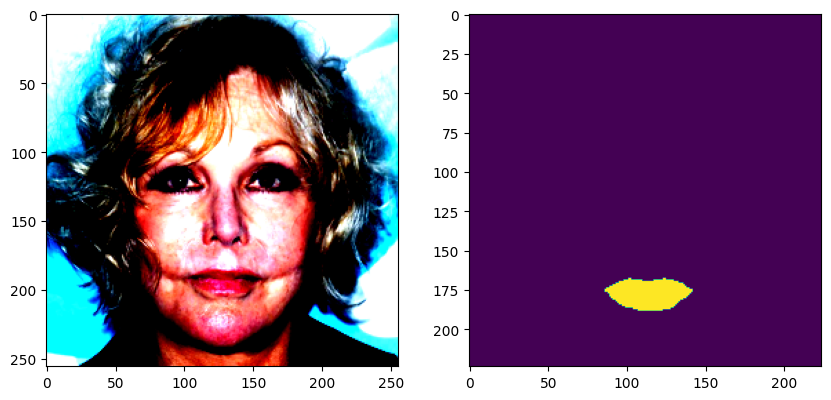

In [56]:
for imgs, masks in train_loader:
    print(imgs.shape)
    print(masks.shape)
    print(masks.min(), masks.max())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(imgs[0].permute(1, 2, 0))
    ax[1].imshow(masks[0].permute(1, 2, 0))
    break

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cpu')

## Model

In [18]:
BACKBONE = 'resnet50'

segmodel = smp.Unet(encoder_name=BACKBONE, classes=1, activation='sigmoid')
segmodel.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [19]:
criterion = utils.losses.DiceLoss()
metrics = [utils.metrics.IoU(), ]
optimizer = optim.Adam(segmodel.parameters(), lr=0.001)

In [20]:
train_epoch = utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    optimizer=optimizer,
    device=device,
    verbose=True
)

valid_epoch = utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics,
    device=device,
    verbose=True
)

In [21]:
max_score = 0

for i in range(1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model_n.pth')
        print('Model saved!') 

Epoch: 1
valid: 100%|██████████| 50/50 [00:16<00:00,  2.99it/s, dice_loss - 0.09999, iou_score - 0.8324]
Model saved!


In [22]:
data_iter = iter(test_loader)

images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

In [24]:
images, labels = next(data_iter)

images, labels = images.to(device), labels.to(device)

outputs = segmodel(images)

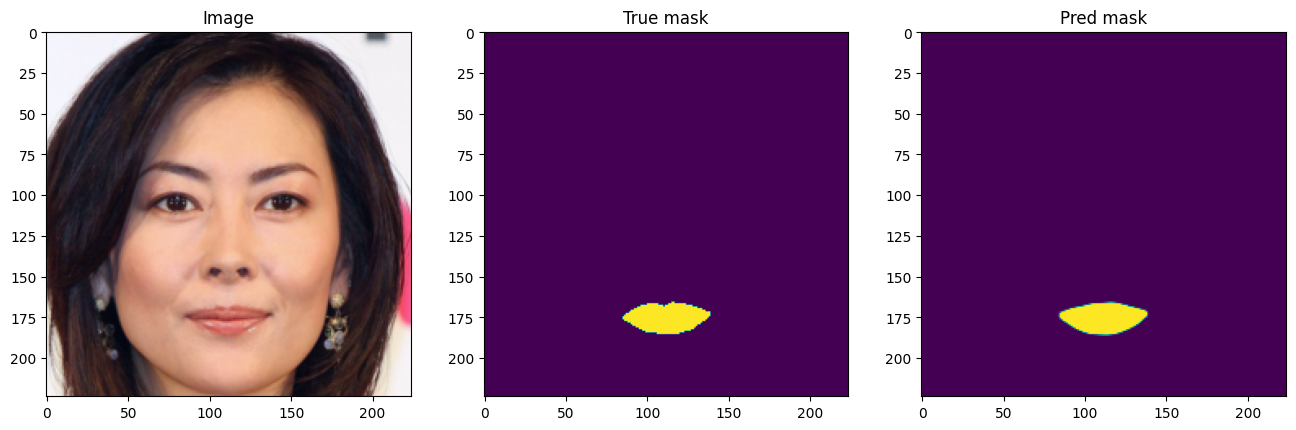

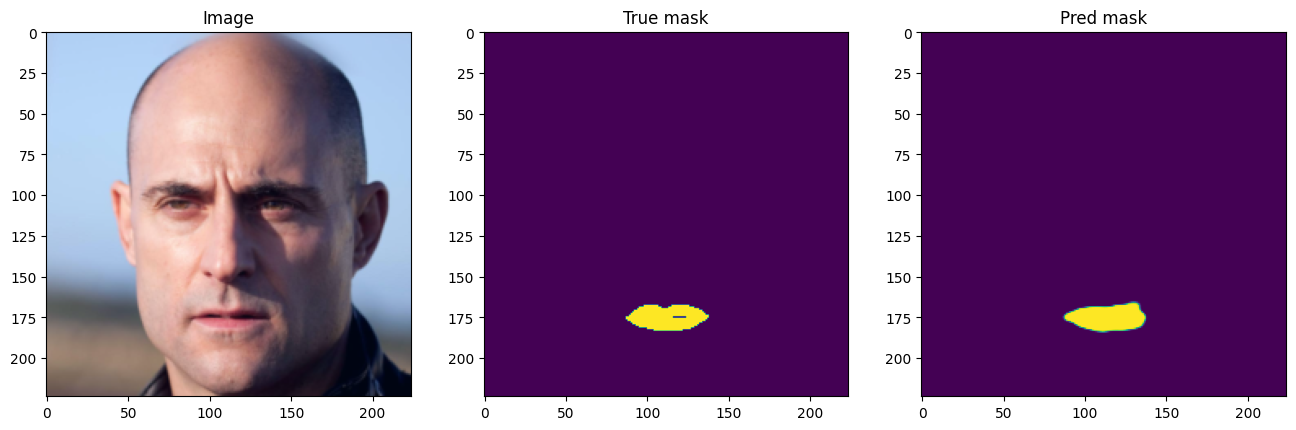

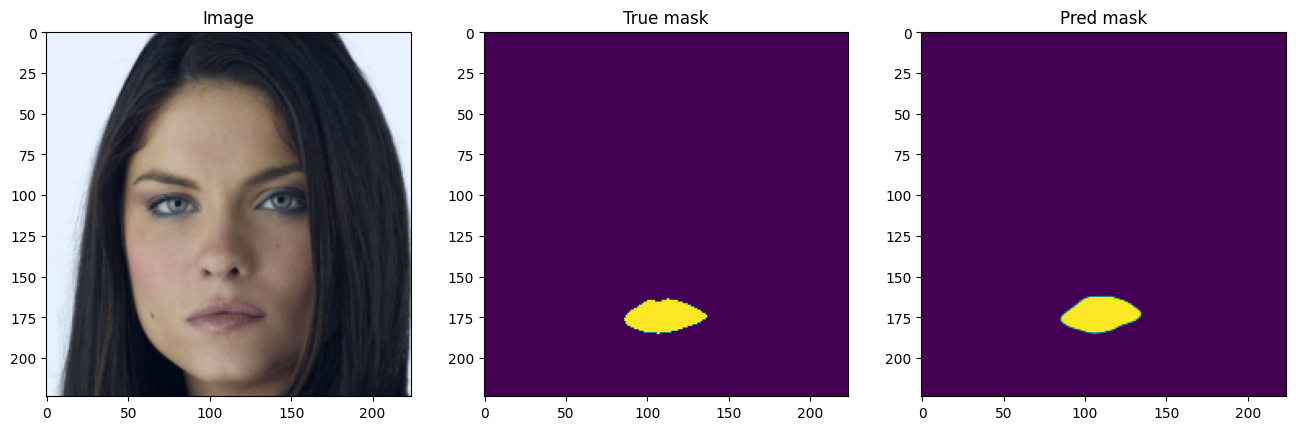

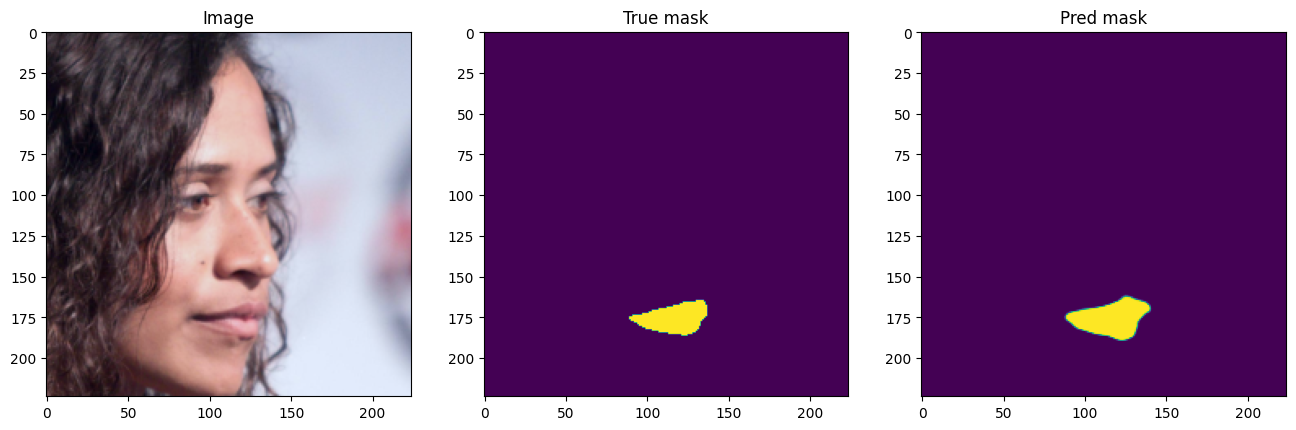

In [66]:
for i in range(images.shape[0]):
    
    fig , (ax_1, ax_2, ax_3) = plt.subplots(1, 3, figsize=(16,5))
    
    image = images[i].permute(1, 2, 0)
    image = (image - image.min()) / (image.max() - image.min())
    
    ax_1.imshow(image.cpu())
    ax_1.set_title('Image')
    
    ax_2.imshow(labels[i, ].cpu().permute(1, 2, 0))
    ax_2.set_title('True mask')
    
    ax_3.imshow(outputs.detach().cpu()[i, ].permute(1, 2, 0))
    ax_3.set_title('Pred mask')

## Wyświetlanie pojedynczego zdjęcia 

In [67]:
def preprocess_img(img_path):
        
    image_transform = transforms.Compose([transforms.Resize((256, 256), 2),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(),
                                        ])
    img = Image.open(img_path).convert("RGB")
    img = image_transform(img)
    return img 

In [70]:
image = preprocess_img(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\WIN_20241030_16_48_01_Pro.jpg')

In [72]:
import numpy as np
# 3. Przenieś obraz na urządzenie
image = image.unsqueeze(0).to(device)  # Dodaj wymiar batcha i przenieś na GPU/CPU

    # 4. Przełącz model w tryb ewaluacji
segmodel.eval()

    # 5. Wykonaj prognozę
with torch.no_grad():  # Dezaktywacja gradientów
    output = segmodel(image)  # Wykonaj forward pass przez model

    # 6. Konwertuj wyjście na numpy do wyświetlenia
output_image = output.squeeze(0).cpu().numpy()  # Usuń wymiar batcha i przenieś na CPU
output_image = (output_image > 0.5).astype(np.uint8)  # Ustal próg dla maski

    # Wyświetl wyniki
show_image(cv2.cvtColor(cv2.imread(r'C:\Users\aleks\OneDrive\Pictures\Camera Roll\WIN_20241030_16_48_01_Pro.jpg'), cv2.COLOR_BGR2RGB), title='Original Image')
show_image(output_image[0], title='Output Mask') 

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 1, 3, 224, 224]